# Laboratorio 7. Autoencoder, Isolation Forest y LOF

In [19]:
from sklearn.datasets import fetch_covtype
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

## Carga de los datos

In [20]:
# Cargar dataset
covtype = fetch_covtype(as_frame=True)  # lo pedimos como DataFrame
X = covtype.data
y = covtype.target  # Cover_Type original (1–7)

# Revisar estructura
print(X.shape)
print(X.head())
print(y.value_counts())

(581012, 54)
   Elevation  Aspect  Slope  ...  Soil_Type_37  Soil_Type_38  Soil_Type_39
0     2596.0    51.0    3.0  ...           0.0           0.0           0.0
1     2590.0    56.0    2.0  ...           0.0           0.0           0.0
2     2804.0   139.0    9.0  ...           0.0           0.0           0.0
3     2785.0   155.0   18.0  ...           0.0           0.0           0.0
4     2595.0    45.0    2.0  ...           0.0           0.0           0.0

[5 rows x 54 columns]
Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


## Escalar datos

In [21]:
# Separar numéricas y binarias
X_num = X.iloc[:, :10]     # primeras 10 columnas numéricas
X_bin = X.iloc[:, 10:]     # resto: binarias (0/1)

# Escalar numéricas
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)

# Unir de nuevo
X_scaled = pd.concat([X_num_scaled, X_bin], axis=1)

## Etiquetar

In [22]:
y_binary = np.where(y == 2, 1, 0)  # 1 = normal, 0 = anómalo

# Revisar proporción
pd.Series(y_binary).value_counts(normalize=True)

,proportion
0,0.512401
1,0.487599


## Autocodificador

### División train/val/test

In [23]:
from sklearn.model_selection import train_test_split

# Dividimos train+val vs test (incluyendo normales y anómalos en test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# De X_temp nos quedamos solo con los normales (para entrenar el AE)
X_temp_norm = X_temp[y_temp == 1]

# train y val (solo normales)
X_train, X_val = train_test_split(
    X_temp_norm, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape, " (con normales y anomalías)")

Train: (181312, 54)
Val: (45329, 54)
Test: (116203, 54)  (con normales y anomalías)


### Modelo

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, Model, Input

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, f1_score

In [25]:
input_dim = X_train.shape[1]

# Definir el modelo
input_layer = keras.Input(shape=(input_dim,))

# Encoder
encoded = layers.Dense(32, activation="relu")(input_layer)
encoded = layers.Dense(16, activation="relu")(encoded)
bottleneck = layers.Dense(8, activation="relu")(encoded)

# Decoder (simétrico)
decoded = layers.Dense(16, activation="relu")(bottleneck)
decoded = layers.Dense(32, activation="relu")(decoded)
output_layer = layers.Dense(input_dim, activation="sigmoid")(decoded)

autoencoder = keras.Model(inputs=input_layer, outputs=output_layer)

# Compilación con MSE
autoencoder.compile(optimizer="adam", loss="mse")

# Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Entrenamiento
history = autoencoder.fit(
    X_train,
    X_train,  # se entrena a reconstruir la entrada
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stop]
)

Epoch 1/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.2041 - val_loss: 0.1166
Epoch 2/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1151 - val_loss: 0.1102
Epoch 3/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1100 - val_loss: 0.1086
Epoch 4/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1085 - val_loss: 0.1081
Epoch 5/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1081 - val_loss: 0.1072
Epoch 6/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1073 - val_loss: 0.1063
Epoch 7/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1064 - val_loss: 0.1060
Epoch 8/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1060 - val_loss: 0.1057
Epoch 9/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1061 - val_loss: 0.1056
Epoch 10/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1062 - val_loss: 0.1055
Epoch 11/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1055 - val_loss: 0.1054
Epoch 12/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

In [51]:
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder con Batch Normalization y Dropout
encoded = layers.Dense(128, activation="relu")(input_layer)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)

encoded = layers.Dense(64, activation="relu")(encoded)
encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.2)(encoded)

encoded = layers.Dense(32, activation="relu")(encoded)
encoded = layers.BatchNormalization()(encoded)

# Bottleneck más grande
bottleneck = layers.Dense(32, activation="relu")(encoded)

# Decoder simétrico
decoded = layers.Dense(32, activation="relu")(bottleneck)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(64, activation="relu")(decoded)
decoded = layers.BatchNormalization()(decoded)

decoded = layers.Dense(128, activation="relu")(decoded)
decoded = layers.BatchNormalization()(decoded)

# Salida lineal para datos estandarizados (NO sigmoid)
output_layer = layers.Dense(input_dim, activation="linear")(decoded)

ae = Model(inputs=input_layer, outputs=output_layer)

# MSE es mejor que MAE para autoencoders
ae.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse"
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )
]

history2 = ae.fit(
    X_train, X_train,
    epochs=150,
    batch_size=128,  # Batch más pequeño
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

Epoch 1/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.1860 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 2/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0376 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 3/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0277 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 4/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0224 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 5/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0192 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 6/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0167 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 7/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0149 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 8/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0134 - val_loss: 0.0043 - learning_rate: 0.0010
Epoch 9/150
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0124 - val_loss: 0.0036 - lear

### Métricas AE1

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
5666/5666 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


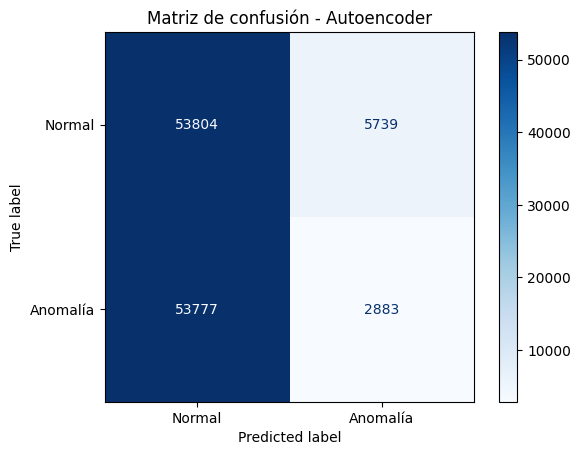

In [42]:
# Predicciones del autoencoder
X_test_pred = autoencoder.predict(X_test)

# Error de reconstrucción (MSE fila por fila)
reconstruction_errors = np.mean(np.square(X_test - X_test_pred), axis=1)

# Calcular umbral (ej: percentil 95 del error en train)
train_pred = autoencoder.predict(X_train)
train_errors = np.mean(np.square(X_train - train_pred), axis=1)
threshold = np.percentile(train_errors, 95)

# Predicciones binarias
y_pred_binary = (reconstruction_errors > threshold).astype(int)  # 1 = anomalía

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Anomalía"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Autoencoder")
plt.show()

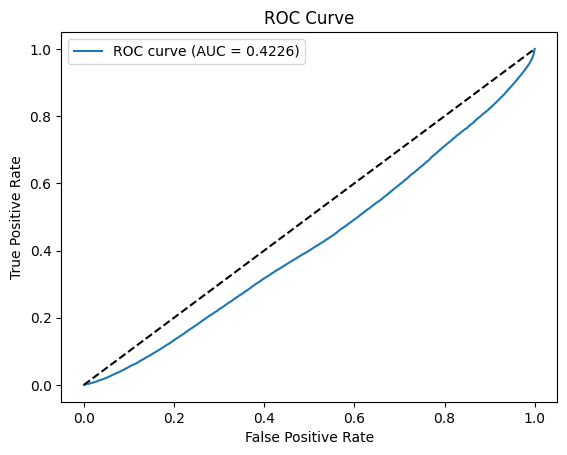

In [33]:
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors)
roc_auc = roc_auc_score(y_test, reconstruction_errors)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

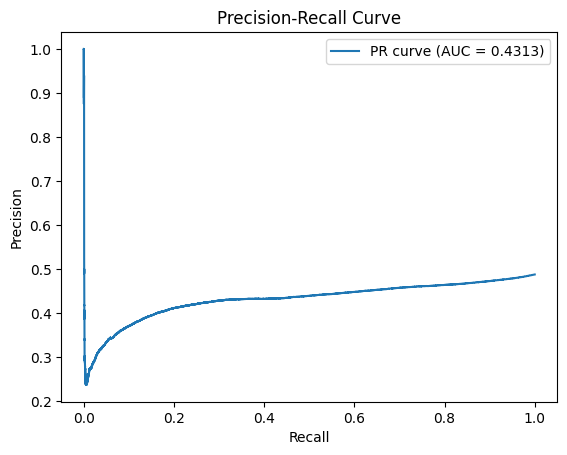

In [34]:
precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)
pr_auc = average_precision_score(y_test, reconstruction_errors)

plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [35]:
f1 = f1_score(y_test, y_pred_binary)
print("F1@umbral:", f1)

F1@umbral: 0.08832449986213657


In [36]:
def precision_at_k(y_true, scores, k):
    # Ordenar por score (descendente)
    idx = np.argsort(scores)[::-1]
    top_k = idx[:k]
    return np.mean(y_true[top_k])

for k in [10, 50, 100]:
    print(f"Precision@{k}: {precision_at_k(y_test, reconstruction_errors, k):.4f}")

Precision@10: 0.9000
Precision@50: 0.7000
Precision@100: 0.4900


### Métricas AE2

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
5666/5666 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step


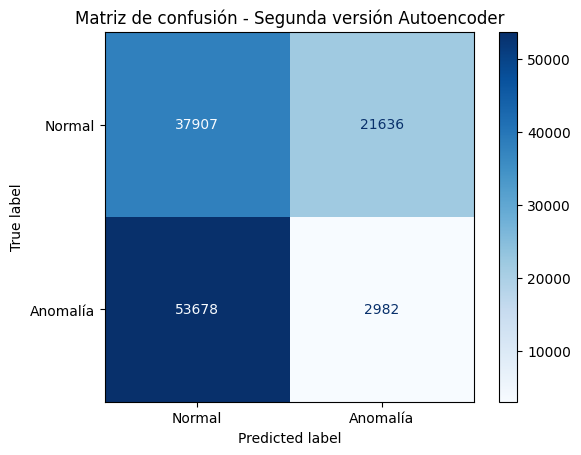

In [52]:
## Autoencoder 2
# Predicciones del autoencoder
X_test_pred2 = ae.predict(X_test)

# Error de reconstrucción (MSE fila por fila)
reconstruction_errors2 = np.mean(np.square(X_test - X_test_pred2), axis=1)

# Calcular umbral (ej: percentil 95 del error en train)
train_pred2 = ae.predict(X_train)
train_errors2 = np.mean(np.square(X_train - train_pred2), axis=1)
threshold2 = np.percentile(train_errors2, 95)

# Predicciones binarias
y_pred_binary2 = (reconstruction_errors2 > threshold2).astype(int)  # 1 = anomalía

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_binary2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal","Anomalía"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión - Segunda versión Autoencoder")
plt.show()

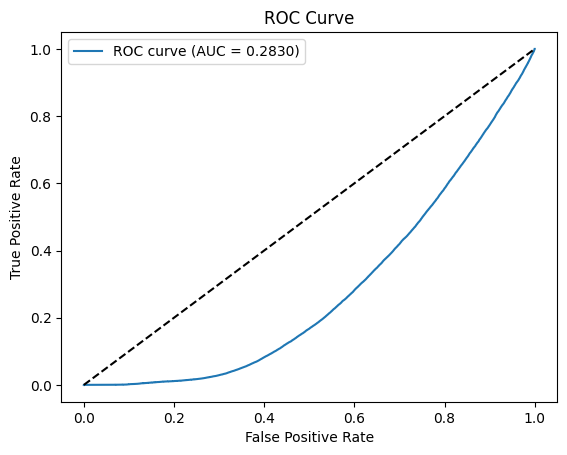

In [47]:
fpr, tpr, _ = roc_curve(y_test, reconstruction_errors2)
roc_auc = roc_auc_score(y_test, reconstruction_errors2)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

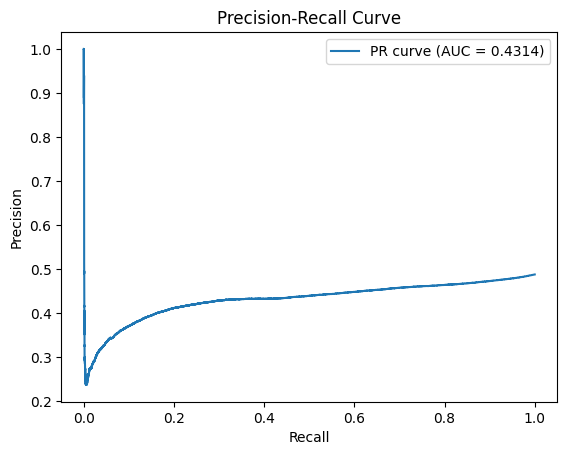

In [54]:
precision, recall, _ = precision_recall_curve(y_test, reconstruction_errors)
pr_auc = average_precision_score(y_test, reconstruction_errors)

plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [55]:
f1 = f1_score(y_test, y_pred_binary2)
print("F1@umbral:", f1)

F1@umbral: 0.07337778980782007


In [57]:
def precision_at_k(y_true, scores, k):
    # Ordenar por score (descendente)
    idx = np.argsort(scores)[::-1]
    top_k = idx[:k]
    return np.mean(y_true[top_k])

for k in [10, 50, 100]:
    print(f"Precision@{k}: {precision_at_k(y_test, reconstruction_errors2, k):.4f}")

Precision@10: 0.8000
Precision@50: 0.2600
Precision@100: 0.1300
